In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP, calc_coverage
from preprocess_data import recode_variables_NHANES,recode_variables_LOOK_AHEAD, split_train_cal_test
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler

In [3]:
plots_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/plots'
results_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/results'

In [4]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
NHANES_df = pd.read_csv(f_path, na_values="None")
NHANES_df = recode_variables_NHANES(NHANES_df)

In [16]:
# df.drop(df[df['Female'] == 1].index, inplace=True)
NHANES_df.dropna(inplace=True)

ed_dummies = ['ED_LESS_HS', 'ED_HS_GED', 'ED_SOME_COLL_AA', 'ED_COLL_ABOVE', 'ED_OTHR_DK']
race_dummies = ['HISPANIC', 'WHITE', 'BLACK', 'OTHER_MIXED']

# GENDER = 'MALE'
# if GENDER == 'FEMALE':
#     NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 1]
# else:
#     NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 0]
    
# X = NHANES_df[[ 'AGE', 'WEIGHT', 'HEIGHT', 'BMI'] + race_dummies + ed_dummies]
X = NHANES_df[[ 'AGE', 'FEMALE', 'WEIGHT', 'HEIGHT'] + race_dummies + ed_dummies]

outcome = 'WAIST'
y = NHANES_df[[outcome]]
y = y[outcome].astype(float)

In [17]:
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

In [18]:
from sklearn.linear_model import LinearRegression

NHANES_X, NHANES_y = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)

alpha = 0.05
reg = CP(NHANES_X['train'], NHANES_X['cal'], NHANES_y['train'], NHANES_y['cal'], alpha=alpha, regressor="QR")
# reg.hyperparam_search(n_iter=100)
reg.train()

Fitting lower quantile (0.025)
Fitting median quantile (0.5)
Fitting upper quantile (0.975)


In [19]:
upper_mdl = reg.models['upper']

In [27]:
import shap

# compute the SHAP values for the linear model
background = shap.maskers.Independent(X, max_samples=25)
explainer = shap.Explainer(reg.get_diff, background)
shap_values = explainer(X)

Permutation explainer: 38494it [07:44, 81.02it/s]                           


In [24]:

# Create a df with upper_mdl coefficients and values
upper_mdl_df = pd.DataFrame(upper_mdl.coef_, index=X.columns)

#print both
print(upper_mdl_df)

                         0
AGE               2.911221
FEMALE            0.909908
WEIGHT           18.645623
HEIGHT           -4.643114
HISPANIC         -0.194405
WHITE             0.159659
BLACK            -0.729374
OTHER_MIXED       0.000000
ED_LESS_HS        0.341987
ED_HS_GED         0.260992
ED_SOME_COLL_AA   0.000000
ED_COLL_ABOVE    -0.299832
ED_OTHR_DK       -0.012365


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


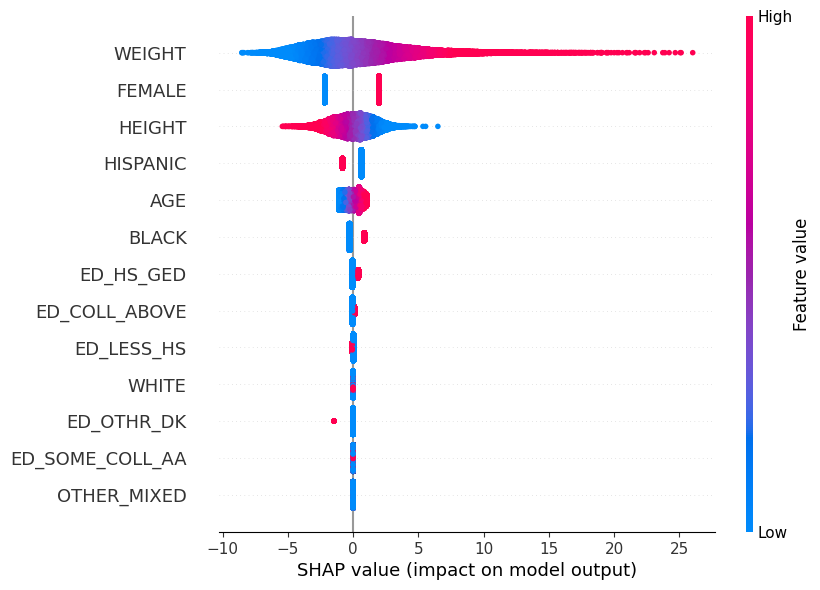

In [28]:
shap.plots.beeswarm(shap_values, max_display=14)